# Phosphoproteomics PCA

Notebook for performing PCA on the protein modification count files.

2020-11-30

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Python-dotenv could not parse statement starting at line 1


Standard variables loaded, you are good to go!


## 1. Loading data

We load the outputs from phosphoCounts:

In [2]:
import pandas as pd

data_file_names = []
data_file_names.append("phosphoCounts_on_Control1.tabular")
data_file_names.append("phosphoCounts_on_Control4.tabular")
data_file_names.append("phosphoCounts_on_Control5.tabular")
data_file_names.append("phosphoCounts_on_KCl2.tabular")
data_file_names.append("phosphoCounts_on_KCl3.tabular")
data_file_names.append("phosphoCounts_on_KCl4.tabular")
data_file_names.append("phosphoCounts_on_NaCl1.tabular")
data_file_names.append("phosphoCounts_on_NaCl2.tabular")
data_file_names.append("phosphoCounts_on_NaCl3.tabular")

phospho_counts = pd.DataFrame()
for data_file_name in data_file_names:
    full_name = join(INTERMEDIATE,data_file_name)
    new_data = pd.read_csv(full_name, index_col=0, sep="\t")
    # Remove trailing stuff:
    for (row_name, row) in new_data.iterrows():
        if '_' in row_name:
            new_name = row_name.split('_')[0]
            new_data = new_data.rename(index={row_name: new_name})
    # add unique ids to repeated proteins:
    v = new_data.groupby(new_data.index)\
      .cumcount()\
      .astype(str)\
      .values
    new_data.index = new_data.index + '_' + v
    # merge to previous data:
    if phospho_counts.empty:
        phospho_counts = new_data
    else:
        phospho_counts = pd.merge(phospho_counts, new_data, left_index=True, right_index=True)
phospho_counts

,Control1,Control4,Control5,KCl2,KCl3,KCl4,NaCl1,NaCl2,NaCl3
ProteinID,,,,,,,,,
B5RSN5_0,0.000000e+00,44401.242190,39835.085940,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
B5RSN5_1,0.000000e+00,14073.941410,8814.108398,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
B5RSP3_0,2.075423e+05,14322.525390,13658.618160,9999.961914,10679.98828,5898.292969,13928.015630,16530.38086,8716.538086
B5RSP7_0,7.611958e+05,603731.250000,809136.375000,339870.468800,338053.78130,125218.742200,551178.687500,371417.28130,462696.125000
B5RSP7_1,1.133454e+06,135862.203100,214135.015600,93648.804690,140241.92190,101762.031300,200198.703100,158438.82810,159369.406300
...,...,...,...,...,...,...,...,...,...
W0TYU0_4,0.000000e+00,0.000000,5483.208984,9276.479492,14842.79492,0.000000,13878.922850,20190.95117,0.000000
W0TYU0_5,0.000000e+00,0.000000,3774.031250,10889.858400,0.00000,0.000000,11950.172850,16047.35840,11597.488280
W0TYU0_6,0.000000e+00,3302.742432,10266.443360,18119.269530,11983.12988,0.000000,30696.933590,27151.83398,17837.859380


## 2. PCA

We will implement a PCA function that can be called several times later:

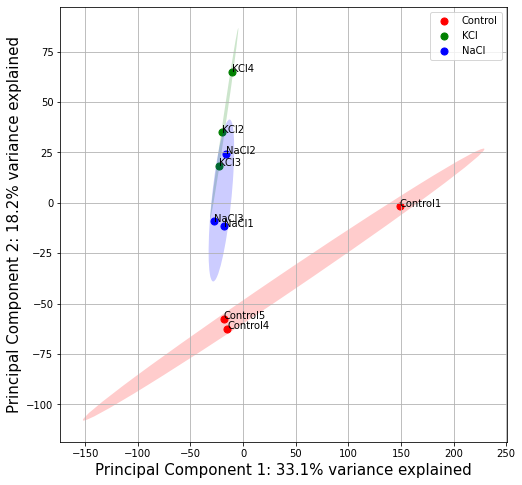

In [3]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# function for running and plotting a PCA:
def plot_PCA(feature_counts):

    # transpose data (variables should be the genes)
    feature_counts = feature_counts.transpose()

    # normalize the data:
    x = feature_counts.loc[:, ].values
    x = StandardScaler().fit_transform(x)

    # run PCA:
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)

    #transform PCA results to dataframe
    pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    pca_df.index = feature_counts.index
    groups = ["Control", "KCl", "NaCl"]
    for (idx, row) in pca_df.iterrows():
        for group in groups:
            if group in idx:
                pca_df.loc[idx,"group"] = group

    # get % of variability from each component
    exp_var_1 = round(pca.explained_variance_ratio_[0]*100, 1)
    exp_var_2 = round(pca.explained_variance_ratio_[1]*100, 1)

    # plot results
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(f'Principal Component 1: {exp_var_1}% variance explained', fontsize = 15)
    ax.set_ylabel(f'Principal Component 2: {exp_var_2}% variance explained', fontsize = 15)
    colors = ["r","g","b"]  # RGB
    for group, color in zip(groups,colors):
        to_keep = pca_df['group'] == group
        x = pca_df.loc[to_keep, 'PC1']
        y = pca_df.loc[to_keep, 'PC2']
        ax.scatter(x, y, c=color, s=50)
        confidence_ellipse(x, y, ax, n_std=2, edgecolor="none", facecolor=color, alpha=0.2, label='_nolegend_')
    ax.legend(groups)
    for (idx, row) in pca_df.iterrows():
        ax.text(row["PC1"], row["PC2"], idx)
    ax.grid()

plot_PCA(phospho_counts)

There is one sample that is affecting too much the analysis (Control1), due to being 1 order of magnitude above the rest in terms of counts:

In [4]:
scaling_factor = phospho_counts.sum(axis=0)
scaling_factor

Control1    7.957246e+09
Control4    7.913742e+08
Control5    7.701671e+08
KCl2        8.263937e+08
KCl3        8.477195e+08
KCl4        8.480985e+08
NaCl1       7.340213e+08
NaCl2       8.628802e+08
NaCl3       7.998859e+08
dtype: float64

So we should normalize somehow

## 3. Effect of data normalization

We will transform the protein modification counts [molecules/sample] to normalized counts [molecules/g], by using the molecular weight information from uniprot:

In [5]:
# Load molecular weights (Da = g/mol) as dictionary:
mws = {}
with open(join(RAW_EXTERNAL,'uniprot_mws.tab')) as f:
    for line in f:
        (key, val) = line.split()
        mws[key] = int(val)

# Create dictionary for modified ids:
mws_phospho = {}
for (row_name, row) in phospho_counts.iterrows():
    mws_phospho[row_name] = mws[row_name.split('_')[0]]

# Convert dataframe to mass-based:
for (row_name, row) in phospho_counts.iterrows():
    phospho_counts.loc[row_name,:] *= mws_phospho[row_name]
phospho_counts

,Control1,Control4,Control5,KCl2,KCl3,KCl4,NaCl1,NaCl2,NaCl3
ProteinID,,,,,,,,,
B5RSN5_0,0.000000e+00,7.057711e+09,6.331906e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
B5RSN5_1,0.000000e+00,2.237095e+09,1.401029e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
B5RSP3_0,3.973708e+10,2.742262e+09,2.615147e+09,1.914643e+09,2.044844e+09,1.129317e+09,2.666728e+09,3.164989e+09,1.668912e+09
B5RSP7_0,7.810935e+10,6.195128e+10,8.302872e+10,3.487547e+10,3.468905e+10,1.284920e+10,5.655865e+10,3.811261e+10,4.747910e+10
B5RSP7_1,1.163082e+11,1.394136e+10,2.197325e+10,9.609678e+09,1.439078e+10,1.044221e+10,2.054319e+10,1.625804e+10,1.635353e+10
...,...,...,...,...,...,...,...,...,...
W0TYU0_4,0.000000e+00,0.000000e+00,3.765374e+08,6.370251e+08,1.019270e+09,0.000000e+00,9.530795e+08,1.386533e+09,0.000000e+00
W0TYU0_5,0.000000e+00,0.000000e+00,2.591665e+08,7.478175e+08,0.000000e+00,0.000000e+00,8.206303e+08,1.101988e+09,7.964111e+08
W0TYU0_6,0.000000e+00,2.268026e+08,7.050069e+08,1.244268e+09,8.228935e+08,0.000000e+00,2.107989e+09,1.864544e+09,1.224944e+09


Now let's see the column sums for each condition:

In [6]:
scaling_factor = phospho_counts.sum(axis=0)
scaling_factor

Control1    5.699295e+14
Control4    5.814649e+13
Control5    5.889522e+13
KCl2        6.100694e+13
KCl3        6.282576e+13
KCl4        6.357502e+13
NaCl1       5.636455e+13
NaCl2       6.374045e+13
NaCl3       6.125145e+13
dtype: float64

Let's normalize this, under the assumption that the same amount of mass was injected in the MS for each sample:

In [7]:
for (column_name, column) in phospho_counts.iteritems():
    phospho_counts[column_name] = column/scaling_factor[column_name]
phospho_counts

,Control1,Control4,Control5,KCl2,KCl3,KCl4,NaCl1,NaCl2,NaCl3
ProteinID,,,,,,,,,
B5RSN5_0,0.000000,0.000121,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B5RSN5_1,0.000000,0.000038,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B5RSP3_0,0.000070,0.000047,0.000044,0.000031,0.000033,0.000018,0.000047,0.000050,0.000027
B5RSP7_0,0.000137,0.001065,0.001410,0.000572,0.000552,0.000202,0.001003,0.000598,0.000775
B5RSP7_1,0.000204,0.000240,0.000373,0.000158,0.000229,0.000164,0.000364,0.000255,0.000267
...,...,...,...,...,...,...,...,...,...
W0TYU0_4,0.000000,0.000000,0.000006,0.000010,0.000016,0.000000,0.000017,0.000022,0.000000
W0TYU0_5,0.000000,0.000000,0.000004,0.000012,0.000000,0.000000,0.000015,0.000017,0.000013
W0TYU0_6,0.000000,0.000004,0.000012,0.000020,0.000013,0.000000,0.000037,0.000029,0.000020


We can confirm the normalization is working as expected by checking the sum of each sample:

In [8]:
phospho_counts.sum(axis=0)

Control1    1.0
Control4    1.0
Control5    1.0
KCl2        1.0
KCl3        1.0
KCl4        1.0
NaCl1       1.0
NaCl2       1.0
NaCl3       1.0
dtype: float64

Now let's convert back to molar amounts:

In [9]:
for (row_name, row) in phospho_counts.iterrows():
    phospho_counts.loc[row_name,:] /= mws_phospho[row_name]
phospho_counts

,Control1,Control4,Control5,KCl2,KCl3,KCl4,NaCl1,NaCl2,NaCl3
ProteinID,,,,,,,,,
B5RSN5_0,0.000000e+00,7.636100e-10,6.763722e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
B5RSN5_1,0.000000e+00,2.420428e-10,1.496575e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
B5RSP3_0,3.641543e-10,2.463179e-10,2.319139e-10,1.639151e-10,1.699938e-10,9.277690e-11,2.471059e-10,2.593390e-10,1.423075e-10
B5RSP7_0,1.335596e-09,1.038293e-08,1.373858e-08,5.571013e-09,5.380815e-09,1.969622e-09,9.778818e-09,5.827027e-09,7.554044e-09
B5RSP7_1,1.988761e-09,2.336550e-09,3.635864e-09,1.535052e-09,2.232236e-09,1.600661e-09,3.551855e-09,2.485687e-09,2.601888e-09
...,...,...,...,...,...,...,...,...,...
W0TYU0_4,0.000000e+00,0.000000e+00,9.310109e-11,1.520561e-10,2.362533e-10,0.000000e+00,2.462349e-10,3.167683e-10,0.000000e+00
W0TYU0_5,0.000000e+00,0.000000e+00,6.408044e-11,1.785020e-10,0.000000e+00,0.000000e+00,2.120157e-10,2.517610e-10,1.893423e-10
W0TYU0_6,0.000000e+00,5.680037e-11,1.743171e-10,2.970034e-10,1.907359e-10,0.000000e+00,5.446141e-10,4.259750e-10,2.912235e-10


We can now repeat yet again the PCA:

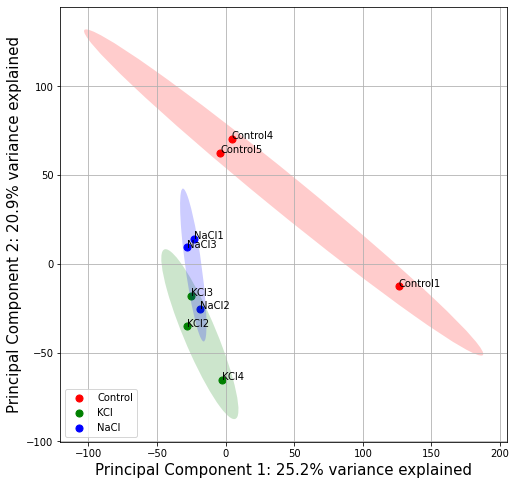

In [10]:
plot_PCA(phospho_counts)

We see ~46% of the variability explained, and the control separated from the two types of stress.

In [11]:
phospho_counts.to_csv(join(INTERMEDIATE,'phosphoCounts_normalized.csv'))